# Spatial mapping of cell types across the mouse brain (1/3) - estimating reference expression signatures of cell types

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig 1A). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. In this notebook we estimate these signatures. 

The **cell2location** workflow has 3 main components:

The cell2location workflow consists of three sections:


I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3):

1. Loading Visium data and single cell reference, QC
2. Exploring the data: UMAP of cells and locations
3. cell2location analysis in one step

III. Results and downstream analysis (3/3):

1. Loading cell2location results
2. Visialising cell locations
3. Automatic discrete region identification by clustering cell densities
4. Analyse cell type density gradients using diffusion maps
5. Identify co-occuring cell type combinations using matrix factorisation



## Loading packages and setting up GPU

First, we need to load the relevant packages and tell cell2location to use the GPU. cell2location is written in pymc3 language for probabilistic modelling that uses a deep learning library called theano for heavy computations. While the package works on both GPU and CPU, using the GPU significantly shortens the computation time for 10X Visium datasets  to 15-20 minutes per sample. Using the CPU is more feasible for smaller datasets with fewer spatial locations (e.g. Nanostring WTA technology). 

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'
#os.environ["OMP_NUM_THREADS"] = '8'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


**Tips on initializing GPU** 
`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU. E.g. failure to use cuDNN will lead to significant slowdown.    
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/'

## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "rawdata/all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(results_folder2 + 'snRNA_annotation_astro_subtypes_refined58_20200828.csv', index_col=0)

Add cell type labels as columns in `adata.obs`

In [3]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.05% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance.

Trying to set attribute `.obs` of view, copying.


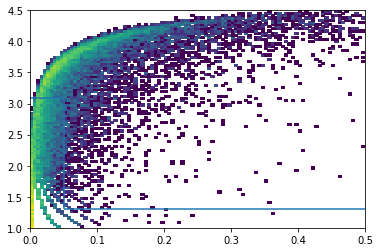

In [4]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

Show the number of selected cells and genes:

In [5]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(40532, 12819)

Filter the object:

In [6]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

Add counts matrix as `adata.raw` 

In [7]:
adata_snrna_raw.raw = adata_snrna_raw

## 3. Show UMAP of cells <a name="3.-Show-UMAP-of-cells"></a>

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

In [8]:
#########################
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
sc.pp.log1p(adata_snrna_raw)

sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=80, use_highly_variable=False)
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw.obsm['X_pca'] = adata_snrna_raw.obsm['X_pca'][:, 1:]
adata_snrna_raw.varm['PCs'] = adata_snrna_raw.varm['PCs'][:, 1:]
#########################

import bbknn
bbknn.bbknn(adata_snrna_raw, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 79)
sc.tl.umap(adata_snrna_raw, min_dist = 0.8, spread = 1.5)

#########################

adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].argsort(),:]

Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


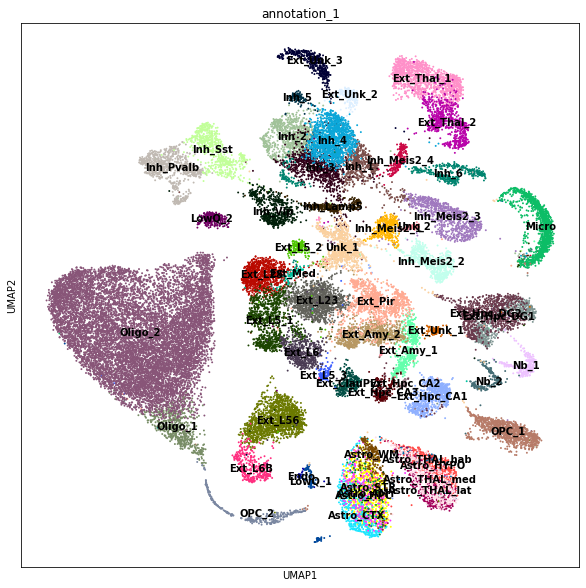

In [9]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

To address the usage of challenging reference data composed of multiple batches $e=\{1..E\}$
and technologies $t=\{1..T\}$ (optional) the expression of each gene $g$ in each single cell reference
cluster $f$ (possibly other meaningful covariates) is inferred using a regularised Negative Binomial regression.

The model accounts for the sequencing coverage $h_e$, difference in expression level between
technologies $t_{tg}$ (optional) and background expression $b_{eg}$ in each sample $e$.
It models unexplained variance (overdispersion $\alpha_g$) and count nature of the data using
the Negative Binomial distribution. 

![Model diagram](../images/Regression_model_diagram.png)  

### Brief description of the model

See https://cell2location.readthedocs.io/en/latest/cell2location.models.html#module-cell2location.models.RegressionGeneBackgroundCoverageTorch

```python
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)
```

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

### Creating model ### - time 0.04 min
### Analysis name: RegressionGeneBackgroundCoverageTorch_64covariates_40532cells_12819genes
### Training model to determine n_epochs with CV ###


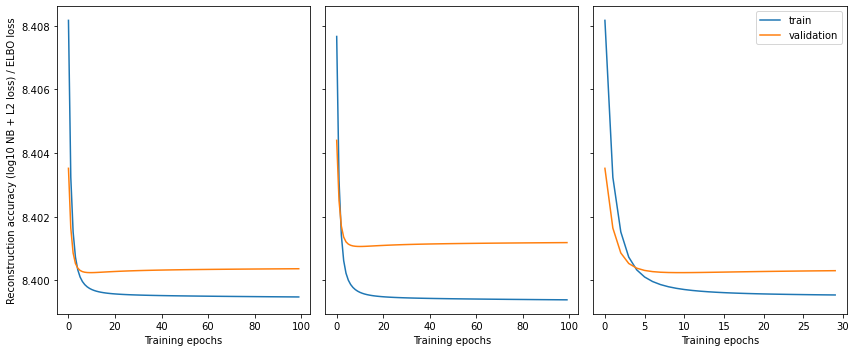

### Re-training model to stop before overfitting ###


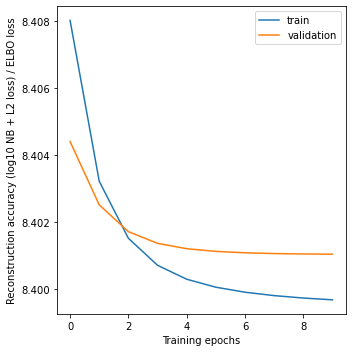

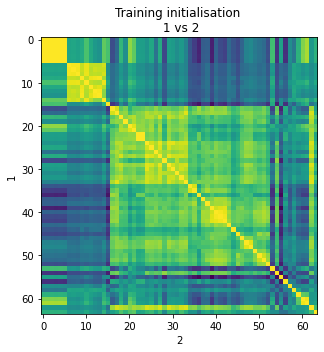

### Evaluating parameters / sampling posterior ### - time 7.27 min


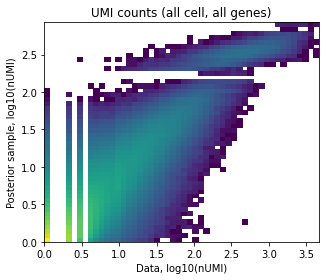

### Saving results ###
### Plotting results ###
Some error in plotting inferred sample_scaling
 "None of [Index(['means_sample_effectsample_5705STDY8058280',\n       'means_sample_effectsample_5705STDY8058281',\n       'means_sample_effectsample_5705STDY8058282',\n       'means_sample_effectsample_5705STDY8058283',\n       'means_sample_effectsample_5705STDY8058284',\n       'means_sample_effectsample_5705STDY8058285'],\n      dtype='object')] are in the [index]"


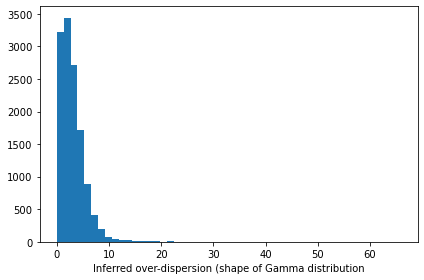

### Done ### - time 8.39 min


In [10]:
# Run the pipeline:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, # input data object]
                   
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], # column listing cell type annotation
                    'sample_name_col': 'sample', # column listing sample ID for each cell
                    
                    # column listing technology, e.g. 3' vs 5', 
                    # when integrating multiple single cell technologies corresponding 
                    # model is automatically selected
                    'tech_name_col': None, 
                    
                    'stratify_cv': 'annotation_1', # stratify cross-validation by cell type annotation
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_cuda': True, # use GPU?
                       
                    'train_proportion': 0.9, # proportion of cells in the training set (for cross-validation)
                    'l2_weight': True,  # uses defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={}, # keep defaults
                   posterior_args={}, # keep defaults
                                 
                   export_args={'path': results_folder + 'regression_model/', # where to save results
                                'save_model': True, # save pytorch model?
                                'run_name_suffix': ''})

reg_mod = r['mod']

Saved anndata object and the trained model object can be read later using:
    
```python
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_64covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
## model
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']
```

Export reference expression signatures of cell types:

In [11]:
# Export cell type expression signatures:
covariate_col_names = 'annotation_1'

inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Compare estimated signatures (y-axis) to analytically computed mean expression (x-axis):

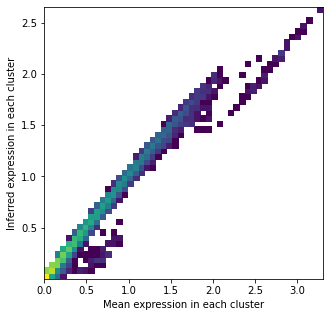

In [12]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, covariate_col_names)
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# compare estimated signatures (y-axis) to analytically computed mean expression (x-axis)
with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

Evaluate whether estimated signatures are less correlated because sample background is now removed:

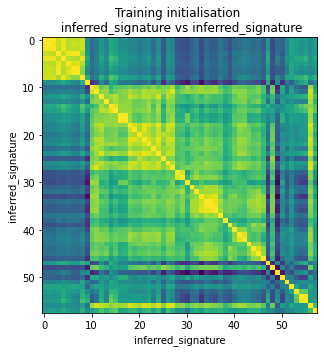

In [13]:
# Look at how correlated are the signatures obtained by computing mean expression
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

# Look at how correlated are the signatures inferred by regression model - they should be less correlated than above
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_signature', 'inferred_signature', align=False)

Compare cell count per experiment to estimated background (soup, free-floating RNA):

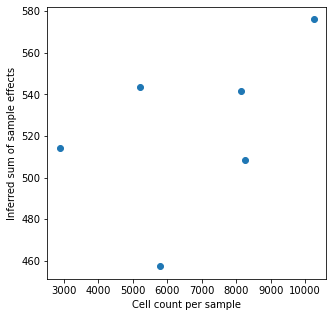

In [14]:
# Examine how many mRNA per cell on average are background 
sample_name_col = 'sample'
cell_count = adata_snrna_raw.obs[sample_name_col].value_counts()
cell_count.index = [f'means_sample_effect{sample_name_col}_{i}' for i in cell_count.index] 
soup_amount = reg_mod.sample_effects.sum(0) 

with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.scatter(cell_count[soup_amount.index].values.flatten(),
                soup_amount.values.flatten());
    plt.xlabel('Cell count per sample'); # fraction of reads in cells
    plt.ylabel('Inferred sum of sample effects');

Supply reference expression signatures to cell2location model (see next notebook):

```python
# Use `inf_aver` for cell2location mapping:
cell2location.run_cell2location(sc_data=inf_aver, ...)
```

## 5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow <a name="5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow"></a>

This allows to identify if the model successfully accounted for technical factor by checking whether removing contribution those factors from every single cell leads to merging of samples / batches, yet preserves well-separated cell types.

In [15]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
del adata_snrna_raw_cor.uns['log1p']

adata_snrna_raw_cor.X = np.array(reg_mod.normalise(adata_snrna_raw_cor.raw.X.copy()))

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=80, use_highly_variable=False)

adata_snrna_raw.obs['total_counts'] = np.array(adata_snrna_raw.raw.X.sum(1)).flatten()
adata_snrna_raw_cor.obs['total_counts'] = adata_snrna_raw.obs['total_counts']

#sc.pl.pca(adata_snrna_raw_cor, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data', vmax='p99.9',
#          legend_fontsize=10)

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw_cor.obsm['X_pca'] = adata_snrna_raw_cor.obsm['X_pca'][:, 1:]
adata_snrna_raw_cor.varm['PCs'] = adata_snrna_raw_cor.varm['PCs'][:, 1:]

sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 79, metric='cosine')
sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.8, spread = 1)

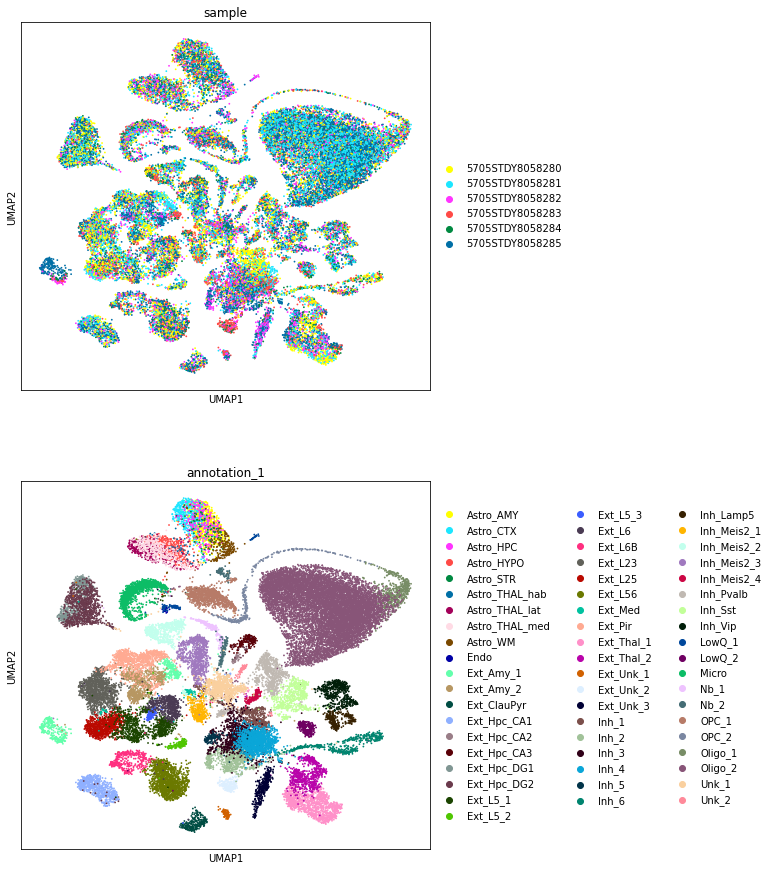

In [16]:
with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw_cor, color=["sample", 'annotation_1'],
               color_map = 'RdPu', ncols = 1, size=13, #legend_loc='on data',
               legend_fontsize=10, palette=sc.pl.palettes.default_102)

Modules and their versions used for this analysis

In [17]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.18.1
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 